K_VALUES        = [5, 10, 20, 30, 40, 50, 75, 100]
ndcg_cosine     = [0.0188608803010249, 0.01653152457992532, 0.015556414351053136, 0.014751037994475797, 0.014420493027289745, 0.014699229419029234, 0.014572143952163571, 0.014810177624732062]
ndcg_jaccard    = [0.020982577518764426, 0.018336679913634385, 0.016161921630730165, 0.015553884626697576, 0.015821707877889363, 0.015811116468219328, 0.015866560943722526, 0.015873630029530256]
ndcg_pearson    = [0.018535159603636924, 0.016253966441879455, 0.015108892726392582, 0.014183270778053026, 0.01363015595274982, 0.014065215833775636, 0.01436727009022342, 0.014186114823516664]


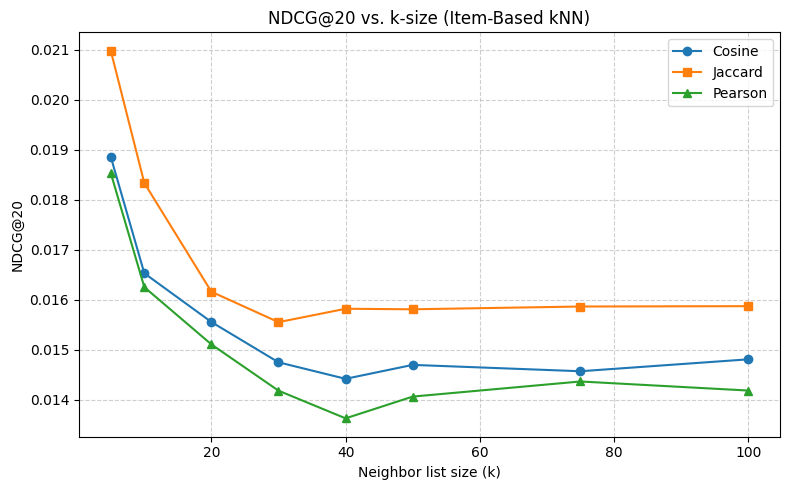

In [ ]:
import math, random
import numpy as np
from collections import defaultdict
from math import log2

INPUT_FILE = "train-1.txt"   # change path if needed
TOPN = 20
K_VALUES = [5, 10, 20, 30, 40, 50, 75, 100]
TEST_FRAC = 0.2
RNG_SEED = 42
random.seed(RNG_SEED)

# ---------- IO ----------
def read_user_items(path):
    ui = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            toks = line.strip().split()
            if len(toks) < 2: 
                continue
            u, items = toks[0], toks[1:]
            ui[u] = set(items)
    return ui

def split_train_test(user_items, test_frac=0.2):
    train, test = {}, {}
    for u, items in user_items.items():
        items = list(items)
        if len(items) <= 1:
            train[u] = set(items)
            continue
        n_test = max(1, int(len(items)*test_frac))
        tset = set(random.sample(items, n_test))
        tr = set(items) - tset
        if tr:
            train[u] = tr
            if tset:
                test[u] = tset
    return train, test

# ---------- metrics ----------
def ndcg_at_k(recommended, ground_truth, k=20):
    dcg = 0.0
    for i in range(min(k, len(recommended))):
        if recommended[i] in ground_truth:
            dcg += 1.0 / log2(i+2)
    ideal = min(len(ground_truth), k)
    if ideal == 0: 
        return 0.0
    idcg = sum(1.0 / log2(i+2) for i in range(ideal))
    return dcg / idcg

def average_ndcg(recs, test, k=20):
    vals = []
    for u, rlist in recs.items():
        gt = test.get(u, set())
        if gt:
            vals.append(ndcg_at_k(rlist, gt, k))
    return float(np.mean(vals)) if vals else 0.0

# ---------- similarities ----------
def compute_pair_counts(user_items):
    co = defaultdict(lambda: defaultdict(int))
    deg = defaultdict(int)
    items_all = set()
    for _, items in user_items.items():
        s = sorted(items)
        items_all.update(s)
        for it in s:
            deg[it] += 1
        for i in range(len(s)):
            a = s[i]
            for j in range(i+1, len(s)):
                b = s[j]
                co[a][b] += 1
    return co, deg, items_all

def cosine(a,b,c):
    return c / math.sqrt(a*b) if a and b else 0.0

def jaccard(a,b,c):
    u = a + b - c
    return c / u if u else 0.0

def pearson(N,a,b,c):
    if a == 0 or b == 0 or a == N or b == N:
        return 0.0
    num = c - (a*b)/N
    den = math.sqrt(a*(1 - a/N) * b*(1 - b/N))
    return num/den if den else 0.0

def build_neighbors(train_ui, k, sim_type):
    N = len(train_ui)
    co, deg, items_all = compute_pair_counts(train_ui)
    if sim_type == "cosine":
        sim_fn = lambda a,b,c: cosine(a,b,c)
    elif sim_type == "jaccard":
        sim_fn = lambda a,b,c: jaccard(a,b,c)
    else:
        sim_fn = lambda a,b,c: pearson(N,a,b,c)

    nbrs = defaultdict(list)
    for i, row in co.items():
        ai = deg[i]
        for j, c in row.items():
            aj = deg[j]
            s = sim_fn(ai, aj, c)
            if s != 0.0:
                nbrs[i].append((j, s))
                nbrs[j].append((i, s))
    for it in list(nbrs.keys()):
        nbrs[it].sort(key=lambda t: abs(t[1]), reverse=True)
        nbrs[it] = nbrs[it][:k]
    popular = [it for it,_ in sorted(deg.items(), key=lambda kv: (-kv[1], kv[0]))]
    return nbrs, popular

def recommend_user_gpu(user_items_ids, item2idx, nbr_idx, nbr_val, topn=20, popular_items=None, device=None):
    """
    user_items_ids: set of string item IDs for this user (from TRAIN)
    item2idx: map str->int
    nbr_idx, nbr_val: tensors from prepare_torch_neighbors
    Returns: list[str] top-n item IDs (unseen)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    I, K = nbr_idx.shape

    if not user_items_ids:
        # cold start: backfill by popularity
        return (popular_items or [])[:topn]

    # Map seen items -> indices
    seen_idx = [item2idx[it] for it in user_items_ids if it in item2idx]
    if not seen_idx:
        return (popular_items or [])[:topn]

    seen_idx_t = torch.tensor(seen_idx, dtype=torch.long, device=device)  # (m,)

    # Gather neighbor rows for all seen items -> (m, K)
    nb_j   = nbr_idx.index_select(0, seen_idx_t)   # neighbor indices (padded with -1)
    nb_sim = nbr_val.index_select(0, seen_idx_t)   # neighbor weights (padded with 0)

    # Flatten contributions
    flat_j   = nb_j.reshape(-1)                    # (m*K,)
    flat_sim = nb_sim.reshape(-1)

    # Drop pads (-1)
    valid = flat_j >= 0
    flat_j   = flat_j[valid]                       # candidate indices
    flat_sim = flat_sim[valid]                     # their contributions

    # Mask out already-seen candidates
    seen_mask = torch.zeros(I, dtype=torch.bool, device=device)
    seen_mask[seen_idx_t] = True
    not_seen = ~seen_mask[flat_j]
    flat_j   = flat_j[not_seen]
    flat_sim = flat_sim[not_seen]

    if flat_j.numel() == 0:
        # no candidates via neighbors -> popularity backfill
        return [it for it in (popular_items or []) if it not in user_items_ids][:topn]

    # Aggregate: sum(sim) and sum(|sim|) per candidate (for normalization)
    scores = torch.zeros(I, dtype=torch.float32, device=device)
    norms  = torch.zeros(I, dtype=torch.float32, device=device)
    scores.scatter_add_(0, flat_j, flat_sim)
    norms.scatter_add_(0, flat_j, flat_sim.abs())

    # Normalize; set seen to -inf so they're never recommended
    denom = torch.where(norms > 0, norms, torch.ones_like(norms))
    final_scores = scores / denom
    final_scores[seen_idx_t] = -float("inf")

    # Top-N
    n_eff = min(topn, I)
    top_scores, top_idx = torch.topk(final_scores, n_eff, largest=True)
    # Filter any -inf (in case user interacted with almost everything)
    mask_finite = torch.isfinite(top_scores) & (top_scores > -1e30)
    top_idx = top_idx[mask_finite].tolist()

    # Backfill with popularity if needed
    if popular_items:
        # convert indices -> ids
        # We need the id list from prepare_torch_neighbors
        # We'll pass it as a closure, or return it from the caller.
        pass

    return top_idx  # indices; convert to IDs in the caller

def recommend_all_gpu(train_user_items, item_ids, item2idx, nbr_idx, nbr_val, popular_items, topn=20, device=None):
    """
    train_user_items: dict[user_id] -> set(item_id)  (TRAIN)
    item_ids: list[str] (index -> item_id)
    popular_items: list[str] sorted by train popularity
    Returns: dict[user_id] -> list[item_id] (length topn)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    I = len(item_ids)
    idx2item = item_ids

    # Make a popularity backfill list in indices (faster on GPU/CPU mix)
    pop_idx = [item2idx[it] for it in popular_items if it in item2idx]

    all_recs = {}
    for u, items_u in train_user_items.items():
        # indices first
        idx_list = recommend_user_gpu(items_u, item2idx, nbr_idx, nbr_val, topn=topn, device=device)
        # Convert idx->id and backfill by popularity if needed
        ids = []
        seen = items_u
        for j in idx_list:
            ids.append(idx2item[j])
            if len(ids) == topn:
                break
        if len(ids) < topn:
            have = set(ids) | seen
            for j in pop_idx:
                it = idx2item[j]
                if it not in have:
                    ids.append(it)
                    if len(ids) == topn:
                        break
        all_recs[u] = ids
    return all_recs

import torch
import numpy as np

def prepare_torch_neighbors(neighbors, all_items=None, k=None, device=None):
    """
    neighbors: dict[item] -> list[(nbr_item, sim)]   # already pruned to <=k
    Returns two CUDA tensors:
      nbr_idx: (I, K) int64  (-1 padded)
      nbr_val: (I, K) float32 (0 padded)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Build a stable item index (0..I-1)
    if all_items is None:
        item_ids = sorted(neighbors.keys())
    else:
        item_ids = sorted(all_items)
    item2idx = {it: i for i, it in enumerate(item_ids)}
    I = len(item_ids)

    # Determine K from data if not provided
    if k is None:
        k = max((len(v) for v in neighbors.values()), default=0)

    # Allocate (-1 / 0 padding)
    nbr_idx = torch.full((I, k), -1, dtype=torch.long, device=device)
    nbr_val = torch.zeros((I, k), dtype=torch.float32, device=device)

    for it, lst in neighbors.items():
        i = item2idx[it]
        # lst: list[(nbr_item, sim)] — we will keep up to k
        upto = min(k, len(lst))
        if upto == 0: 
            continue
        idxs = [item2idx[nbr] for (nbr, _) in lst[:upto]]
        vals = [float(sim) for (_, sim) in lst[:upto]]
        nbr_idx[i, :upto] = torch.tensor(idxs, dtype=torch.long, device=device)
        nbr_val[i, :upto] = torch.tensor(vals, dtype=torch.float32, device=device)

    return item_ids, item2idx, nbr_idx, nbr_val

# ---------- run experiment ----------
user_items = read_user_items(INPUT_FILE)
train_ui, test_ui = split_train_test(user_items, TEST_FRAC)

ndcg_cosine, ndcg_jaccard, ndcg_pearson = [], [], []
device = "cuda" if torch.cuda.is_available() else "cpu"
for k in K_VALUES:
    # cosine
    nbrs, pop = build_neighbors(train_ui, k, "cosine")
    # Prepare neighbor tensors on GPU (once per k/sim_type)
    item_ids, item2idx, nbr_idx, nbr_val = prepare_torch_neighbors(
        nbrs, all_items=None, k=None, device=device
    )

    # (Optional) ensure popularity refers only to items present in neighbor map
    popular_items = [it for it in pop if it in item2idx]
    recs = recommend_all_gpu(train_user_items=train_ui,
        item_ids=item_ids,
        item2idx=item2idx,
        nbr_idx=nbr_idx,
        nbr_val=nbr_val,
        popular_items=popular_items,
        topn=20,
        device=device)
    ndcg_cosine.append(average_ndcg(recs, test_ui, TOPN))
    # jaccard
    nbrs, pop = build_neighbors(train_ui, k, "jaccard")
    # Prepare neighbor tensors on GPU (once per k/sim_type)
    item_ids, item2idx, nbr_idx, nbr_val = prepare_torch_neighbors(
        nbrs, all_items=None, k=None, device=device
    )

    # (Optional) ensure popularity refers only to items present in neighbor map
    popular_items = [it for it in pop if it in item2idx]
    recs = recommend_all_gpu(train_user_items=train_ui,
        item_ids=item_ids,
        item2idx=item2idx,
        nbr_idx=nbr_idx,
        nbr_val=nbr_val,
        popular_items=popular_items,
        topn=20,
        device=device
    )
    ndcg_jaccard.append(average_ndcg(recs, test_ui, TOPN))
    # pearson
    nbrs, pop = build_neighbors(train_ui, k, "pearson")
    # Prepare neighbor tensors on GPU (once per k/sim_type)
    item_ids, item2idx, nbr_idx, nbr_val = prepare_torch_neighbors(
        nbrs, all_items=None, k=None, device=device
    )

    # (Optional) ensure popularity refers only to items present in neighbor map
    popular_items = [it for it in pop if it in item2idx]
    recs = recommend_all_gpu(train_user_items=train_ui,
        item_ids=item_ids,
        item2idx=item2idx,
        nbr_idx=nbr_idx,
        nbr_val=nbr_val,
        popular_items=popular_items,
        topn=20,
        device=device
    )
    ndcg_pearson.append(average_ndcg(recs, test_ui, TOPN))

print("K_VALUES        =", K_VALUES)
print("ndcg_cosine     =", ndcg_cosine)
print("ndcg_jaccard    =", ndcg_jaccard)
print("ndcg_pearson    =", ndcg_pearson)

# ---------- plot ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(K_VALUES, ndcg_cosine, marker="o", label="Cosine")
plt.plot(K_VALUES, ndcg_jaccard, marker="s", label="Jaccard")
plt.plot(K_VALUES, ndcg_pearson, marker="^", label="Pearson")
plt.xlabel("Neighbor list size (k)")
plt.ylabel("NDCG@20")
plt.title("NDCG@20 vs. k-size (Item-Based kNN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
